In [1]:
#=
using Pkg; 
packages = ["Knet", "AutoGrad", "Random", "Test", "MLDatasets", "CUDA", "Plots", "GR","Statistics",
            "IterTools", "StatsBase", "DSP", "Images", "DelimitedFiles", "MultivariateStats", "PyPlot", "PyCall"];
Pkg.add(packages);
=#

In [2]:
include("../src/modules/TUM69.jl")
include("../src/modules/Preprocess.jl")
include("../src/modules/Network.jl")
include("../src/modules/Utils.jl")

## Third party packages
using Knet: KnetArray, adam, relu, minibatch
using AutoGrad, Knet, CUDA


## Handwritten modules
using .TUM69: load_accel_data   # Data reading
using .Preprocess: process_accel_signal # Preprocessing on the data
using .Network: GCN, train_summarize!, accuracy4, nll4, GenericMLP # Construction of custom network
using .Utils: notify

In [3]:
AutoGrad.set_gc_function(AutoGrad.default_gc)

default_gc (generic function with 1 method)

In [4]:
# Trick from Deniz Hoca to deal with this issue: https://github.com/denizyuret/Knet.jl/issues/524
#=
using Knet
function Knet.KnetArray(x::CuArray{T,N}) where {T,N}
    p = Base.bitcast(Knet.Cptr, pointer(x))
    k = Knet.KnetPtr(p, sizeof(x), Int(CUDA.device().handle), x)
    KnetArray{T,N}(k, size(x))
end
=#

In [5]:
# Array type setting for GPU usage
a_type() = (CUDA.functional() ? KnetArray{Float32} : Array{Float32})

a_type (generic function with 1 method)

In [6]:
# CUDA information
GC.gc(true)
CUDA.device()

CuDevice(0): Tesla V100-SXM2-32GB

In [7]:
path = CUDA.functional() ? "/userfiles/vaydingul20/data/new" : "./../data/trial" # path of the main data
DATA_PATH = isdir(path) && path

"/userfiles/vaydingul20/data/new"

In [8]:
X_train, y_train,
X_test, y_test, 
material_dict = @time load_accel_data(DATA_PATH; mode = "normal");  # Data loading routine

Train accel data is being loaded!
Test accel data is being loaded!
 78.835385 seconds (732.60 M allocations: 24.039 GiB, 2.57% gc time)


In [9]:
println("X_train = ", summary(X_train))
println("y_train = ", summary(y_train))
println("X_test  = ", summary(X_test))
println("y_test  = ", summary(y_test))
println("material_dict = ", summary(material_dict))

X_train = 690-element Array{Array{Float32,1},1}
y_train = 690-element Array{Int8,1}
X_test  = 690-element Array{Array{Float32,1},1}
y_test  = 690-element Array{Int8,1}
material_dict = Dict{String,Int8} with 69 entries


In [10]:
#Preprocessing on the acceleration data
@time X_train_modified, y_train_modified = process_accel_signal(X_train, y_train);
@time X_test_modified, y_test_modified = process_accel_signal(X_test, y_test);

 12.186482 seconds (7.23 M allocations: 6.328 GiB, 3.76% gc time)
  5.735610 seconds (320.21 k allocations: 3.902 GiB, 0.75% gc time)


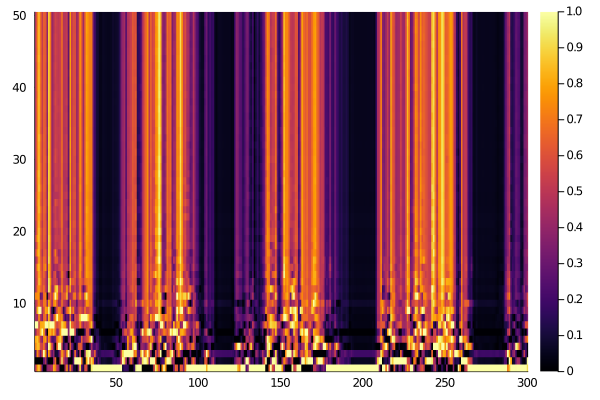

In [28]:
using Plots
heatmap(X_train_modified[:,:,1,4000])

In [12]:
println("X_train = ", summary(X_train_modified))
println("y_train = ", summary(y_train_modified))
println("X_test  = ", summary(X_test_modified))
println("y_test  = ", summary(y_test_modified))
println("material_dict = ", summary(material_dict))

X_train = 50×300×1×4489 Array{Float32,4}
y_train = 4489-element Array{Int8,1}
X_test  = 50×300×1×2223 Array{Float32,4}
y_test  = 2223-element Array{Int8,1}
material_dict = Dict{String,Int8} with 69 entries


In [13]:
# Some constants that will be used in the network model
MINIBATCH_SIZE = 10
INPUT_SIZE = size(X_test_modified)[1:3]
OUTPUT_SIZE = size(collect(keys(material_dict)))[1];

In [14]:
# Minibatching
dtrn = minibatch(X_train_modified, y_train_modified, MINIBATCH_SIZE; xtype = a_type(), shuffle = true)
dtst = minibatch(X_test_modified, y_test_modified, MINIBATCH_SIZE; xtype = a_type(), shuffle = true);

In [15]:
#=
model = GCN(INPUT_SIZE, OUTPUT_SIZE, 
       [(25, 150, 1 , relu, 0.0, (1, 1), (1, 1), (2, 2), false)]; 
    hidden=[10], optimizer_type = sgd, lr = 0.15, loss_fnc=nll, accuracy_fnc = accuracy, atype=a_type())
=#

In [25]:

model = GCN(INPUT_SIZE, OUTPUT_SIZE, 
       [(3, 3, 50 , relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (3, 3, 100, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (3, 3, 150, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (3, 3, 200, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (4, 12,400, relu, 0.5, (1, 0), (1, 1), (1, 1), false),
        (1, 1, 250, relu, 0.5, (0, 0), (1, 1), (1, 1), false),
        (1, 1, OUTPUT_SIZE , relu, 0.5, (0, 0), (1, 1), (1, 1), false),
        ]; 
    hidden=[], optimizer_type = adam, lr = 1e-4, loss_fnc=nll4, accuracy_fnc = accuracy4, atype=a_type())


GCN((Main.Network.Conv(P(KnetArray{Float32,4}(3,3,1,50)), P(KnetArray{Float32,4}(1,1,50,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), false, KnetArray{Float32,N} where N), Main.Network.Conv(P(KnetArray{Float32,4}(3,3,50,100)), P(KnetArray{Float32,4}(1,1,100,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), false, KnetArray{Float32,N} where N), Main.Network.Conv(P(KnetArray{Float32,4}(3,3,100,150)), P(KnetArray{Float32,4}(1,1,150,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), false, KnetArray{Float32,N} where N), Main.Network.Conv(P(KnetArray{Float32,4}(3,3,150,200)), P(KnetArray{Float32,4}(1,1,200,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), false, KnetArray{Float32,N} where N), Main.Network.Conv(P(KnetArray{Float32,4}(4,12,200,400)), P(KnetArray{Float32,4}(1,1,400,1)), Knet.Ops20.relu, 0, (1, 0), (1, 1), (1, 1), false, KnetArray{Float32,N} where N), Main.Network.Conv(P(KnetArray{Float32,4}(1,1,400,250)), P(KnetArray{Float32,4}(1,1,250,1)), Knet.Ops20.relu, 0, (0, 0), (1, 1), (

In [26]:
model(dtst)

4.2342587f0

┣████████████████████┫ [100.00%, 44800/44800, 21:38/21:38, 34.51i/s] 


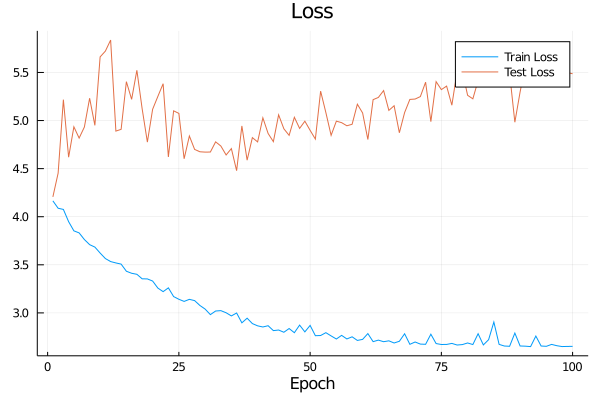

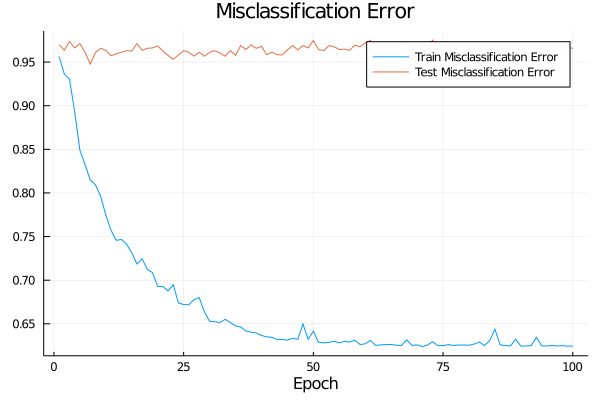

TRAINING PARAMETERS


Activation Function = relu
Optimizer Type = adam
Learning Rate = 0.0001
LAYERS:


Main.Network.Conv ==> W = (3, 3, 1, 50)   b = (1, 1, 50, 1)
Main.Network.Conv ==> W = (3, 3, 50, 100)   b = (1, 1, 100, 1)
Main.Network.Conv ==> W = (3, 3, 100, 150)   b = (1, 1, 150, 1)
Main.Network.Conv ==> W = (3, 3, 150, 200)   b = (1, 1, 200, 1)
Main.Network.Conv ==> W = (4, 12, 200, 400)   b = (1, 1, 400, 1)
Main.Network.Conv ==> W = (1, 1, 400, 250)   b = (1, 1, 250, 1)
Main.Network.Conv ==> W = (1, 1, 250, 69)   b = (1, 1, 69, 1)
In this network configuration,
there are total 4408919 parameters.
Final Loss
Train Loss = 2.6520393
Test Loss = 5.4867735


Final Misclassification Error
Train Misclassification Error = 0.62455356
Test Misclassification Error = 0.9657658


Test Accuracy = 0.033783783783783786


4×100 Array{Float32,2}:
 4.16489  4.08804   4.07589   3.94847   …  2.64999   2.65155   2.65204
 4.20632  4.45307   5.21758   4.6189       5.48625   5.49841   5.48677
 0.95625  0.936384  0.930357  0.89308      0.625     0.62433   0.624554
 0.97027  0.963513  0.973874  0.966216     0.966667  0.966667  0.965766

In [27]:
# Training routine
# Currently, the model is not working due to the issue mentioned in: https://github.com/denizyuret/Knet.jl/issues/624#
# As soon as it is solved, I hope the model will be accurately working.
res = train_summarize!(model, dtrn, dtst; 
                       train_type = "epoch", progress_bar = true ,fig = true, info = true, 
                       epoch = 100, conv_epoch = 50, max_conv_cycle = 20)

In [24]:
notify("OK!")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     3    0     0  100     3      0      2  0:00:01  0:00:01 --:--:--     2

{}

100     5  100     2  100     3      1      1  0:00:03  0:00:01  0:00:02     2


Process(`curl https://notify.run/fnx04zT7QmOlLLa6 -d OK!`, ProcessExited(0))